### Object Detection [Classification+Localization]

### 1: Importing Libraries

In [39]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image,PIL.ImageFont,PIL.ImageDraw
import tensorflow as tf 
import tensorflow_datasets as tfds

### 2: Visualisation Utilities

In [34]:
im_width=75
im_hieght=75
use_normalized_coordinates=True

In [40]:
def draw_bounding_boxes_on_image_array(image, boxes,color=[], thickness=1, display_str_list=()): 
    image_pil=PIL.Image.fromarray(image)
    rgbing=PIL.Image.new("RGBA", image_pil.size)
    rgbing.paste(image_pil)
    draw_bounding_boxes_on_image(image, boxes,color=[], thickness=1, display_str_list=())
    return np.array(rgbing)

def draw_bounding_boxes_on_image(image, boxes,color=[], thickness=1, display_str_list=()):
    boxes_shape=boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) !=2 or boxes_shape[1] !=4:
        raise ValueError('Input must be of size [N,4]')
    for i in rangge (boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i,1], boxes [1,0], boxes [1,3], boxes[1,2], color[i], thickness, display_str_list[i])

def draw_bounding_box_on_image(image, ymin, xmin, ymax, хmах, color='red', thickness=1, use_normalized_coordiates = True):
    draw=PIL.ImageDraw.Draw(image)
    im_width, im_height=image.size
    if use_normalized_coordiates:
        (left, right, top, bottom)=(xmin*im_width, xmax*im_width, ymin*im_height, ymax*im_height)
    else:
        (left, right, top, bottom)=(xmin, xmax, ymin, ymax)

    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

In [82]:
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    batch_train_ds = training_dataset.unbatch().batch(N)

    for training_digits, (training_labels, training_bboxes) in batch_train_ds.take(1):
        training_digits = training_digits.numpy()
        training_labels = training_labels.numpy()
        training_bboxes = tf.stack(training_bboxes, axis=1).numpy()

    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
        validation_digits = validation_digits.numpy()
        validation_labels = validation_labels.numpy()
        validation_bboxes = tf.stack(validation_bboxes, axis=1).numpy()
        break  # Only take one batch

    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)


In [45]:
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(matplotlib.__file__), "mpl-data", "fonts", "ttf")
def create_digits_from_local_fonts(n):
    font_labels=[]
    img=PIL.Image.new('LA', (75*n, 75), color=(0,255))
    Font1=PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR,'DejavusansMono-Oblique.ttf'), 25)
    Font2=PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR,'STIXGeneral.ttf'), 25)
    d=PIL.ImageDraw.Draw(ing) 
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75, 0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2) 
    font_digits=np.array(img.getdata(), np.float32)[:,0]/255.0
    font_digits=np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n,axis=1), axis=0) [n, 75*75])
    return font_digits,font_labels

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_digits_with_boxes(digits, predictions, labels,
                              pred_bboxes=None, bboxes=None, iou=None,
                              title=""):

    # Set defaults
    pred_bboxes = np.array(pred_bboxes) if pred_bboxes is not None else np.array([])
    bboxes = np.array(bboxes) if bboxes is not None else np.array([])
    iou = np.array(iou) if iou is not None else np.array([])

    # Determine max available size safely
    available_n = min(len(digits), len(predictions), len(labels))
    if len(bboxes) > 0:
        available_n = min(available_n, len(bboxes))
    if len(pred_bboxes) > 0:
        available_n = min(available_n, len(pred_bboxes))
    if len(iou) > 0:
        available_n = min(available_n, len(iou))

    n = min(10, available_n)  # Don't exceed available size
    indexes = np.random.choice(available_n, size=n, replace=False)

    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_pred_bboxes = pred_bboxes[indexes] if len(pred_bboxes) > 0 else None
    n_bboxes = bboxes[indexes] if len(bboxes) > 0 else None
    n_iou = iou[indexes] if len(iou) > 0 else None

    n_digits = n_digits / 255.0  # Normalize if needed
    n_digits = n_digits.reshape(n, 75, 75)

    fig = plt.figure(figsize=(20, 4))
    plt.suptitle(title)

    for i in range(n):
        ax = fig.add_subplot(1, n, i + 1)
        boxes_to_plot = []

        if n_pred_bboxes is not None:
            boxes_to_plot.append(n_pred_bboxes[i])
        if n_bboxes is not None:
            boxes_to_plot.append(n_bboxes[i])

        img = n_digits[i]

        # Draw image
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        # Draw bounding boxes
        colors = ['red', 'green']
        labels_str = ['Pred', 'True']
        for j, box in enumerate(boxes_to_plot):
            if len(box) == 4:
                x, y, w, h = box
                rect = patches.Rectangle((x, y), w, h, linewidth=2,
                                         edgecolor=colors[j], facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y - 2, labels_str[j], color=colors[j], fontsize=6)

        # Get prediction and label as scalar if one-hot encoded
        pred_val = np.argmax(n_predictions[i]) if isinstance(n_predictions[i], (np.ndarray, list)) else n_predictions[i]
        true_val = np.argmax(n_labels[i]) if isinstance(n_labels[i], (np.ndarray, list)) else n_labels[i]

        ax.set_xlabel(str(pred_val))
        if pred_val != true_val:
            ax.xaxis.label.set_color('red')

        # Show IoU if available
        if n_iou is not None:
            iou_val = n_iou[i][0] if isinstance(n_iou[i], (list, np.ndarray)) else n_iou[i]
            color = 'black' if iou_val >= 0.5 else 'red'
            ax.text(0.2, -0.3, f"IoU: {iou_val:.2f}", color=color, transform=ax.transAxes)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_metrics(metric_name,title):
    plt.title(title)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_'+ metric_name],color='green',label='val_'+ metric_name)

### 3: Loading And Preprocessin the Dataset

In [51]:
strategy=tf.distribute.get_strategy()
strategy.num_replicas_in_sync

1

In [52]:
# BATCH_SIZE=64*strategy.num_replicas_in_sync
BATCH_SIZE=64

In [75]:
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)

    image = tf.reshape(image, (28, 28, 1))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32) / 255.0

    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
    xmax = (xmin + 28) / 75.0
    ymax = (ymin + 28) / 75.0
    xmin = xmin / 75.0
    ymin = ymin / 75.0

    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

In [78]:
def get_training_dataset(strategy):
    with strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.batch(128)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [79]:
def get_validaty_dataset(strategy):
    with strategy.scope():
        dataset = tfds.load("mnsit", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(10000, drop_remainder=True)
        dataset = dataset.repeat()
    return dataset

In [80]:
with strategy.scope():
    training_dataset = get_training_dataset(strategy)
    validation_dataset = get_validation_dataset(strategy)

In [83]:
(training_digits,training_labels,training_bboxes,
 validation_digits,validation_labels,validation_bboxes)=dataset_to_numpy_util(training_dataset,validation_dataset,10)

### Visualize Data

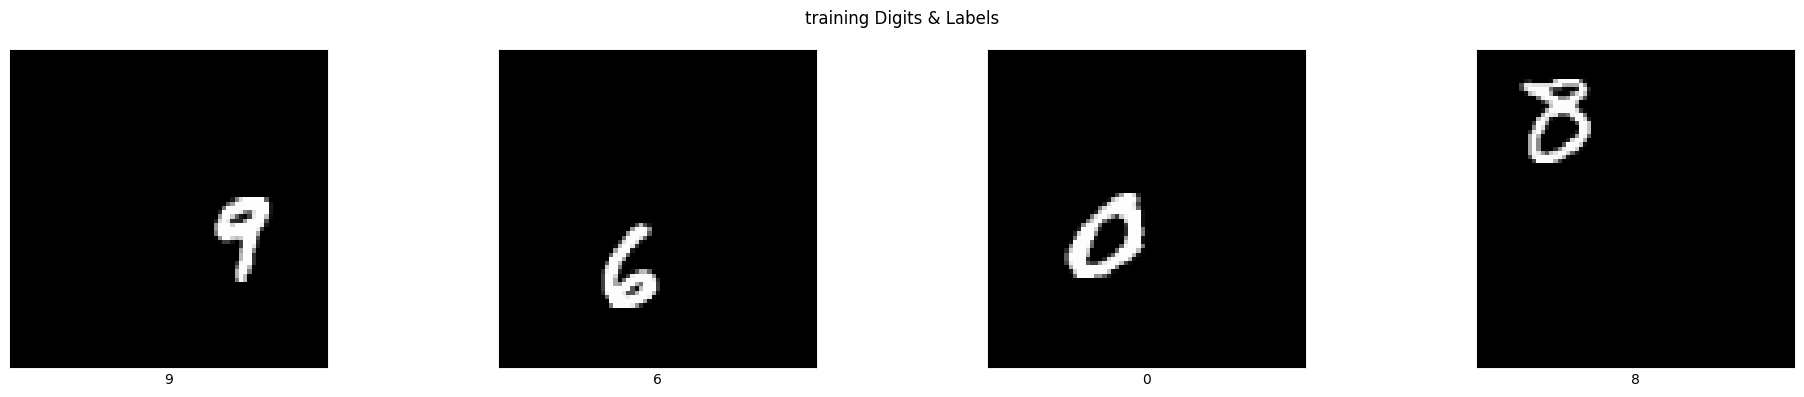

In [97]:
display_digits_with_boxes(training_digits,training_labels,
                          training_labels,np.array([]),training_bboxes,
                          np.array([]),"training Digits & Labels")

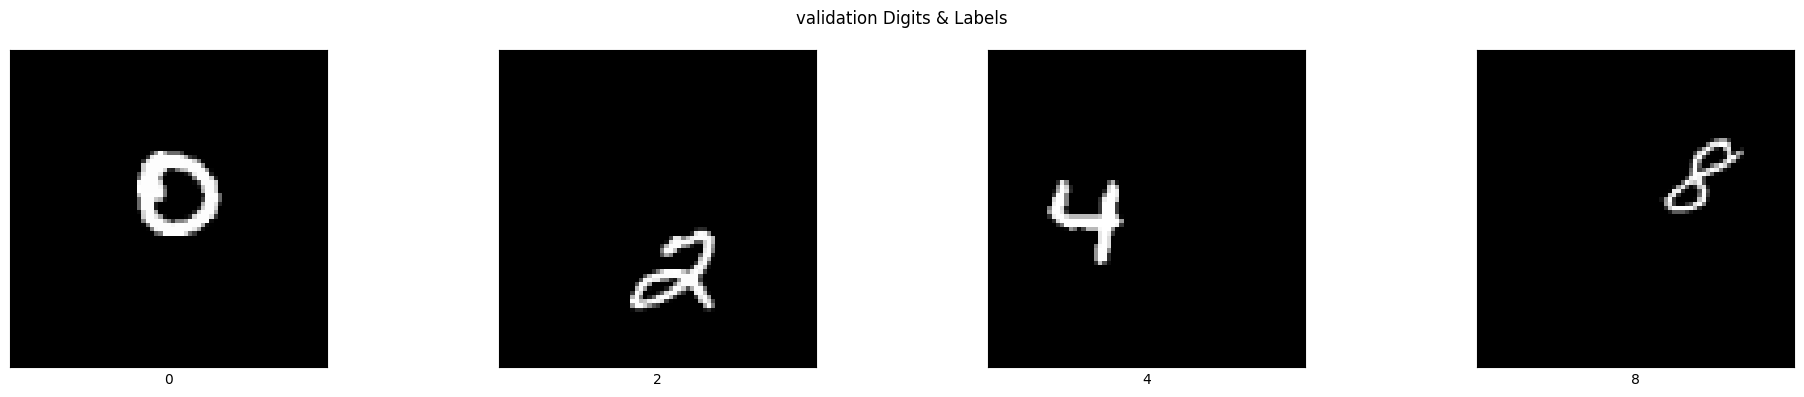

In [98]:
display_digits_with_boxes(validation_digits,validation_labels,
                          validation_labels,np.array([]),validation_bboxes,
                          np.array([]),"validation Digits & Labels")

### 4: Define The Network

In [100]:
def feature_extractor(inputs):
    x=tf.keras.layers.Conv2D(16,activation='relu',kernel_size=3,input_shape=(75,75,1))(inputs)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Conv2D(32,activation='relu',kernel_size=3)(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Conv2D(64,activation='relu',kernel_size=3)(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    return x

In [104]:
def dense_layers(inputs):
     x=tf.keras.layers.Flatten()(inputs)
     x=tf.keras.layers.Dense(128,activation='relu')(x)
     return x

In [105]:
def classifier(inputs):
    classification_output=tf.keras.layers.Dense(10,activation="softmax",name="classification")(inputs)
    return classification_output

In [114]:
def bounding_box_regression(inputs):
    bounding_box_regression_output=tf.keras.layers.Dense(4,name="bounding_box")(inputs)
    return bounding_box_regression_output

In [122]:
def final_model(inputs):
    feature_cnn=feature_extractor(inputs)
    dense_output=dense_layers(feature_cnn)
    classification_output=classifier(dense_output)
    bounding_box_output=bounding_box_regression(dense_output)
    model=tf.keras.Model(inputs=inputs,outputs=[classification_output,bounding_box_output])
    return model

In [123]:
def define_and_compile_model(inputs):
    model=final_model(inputs)
    model.compile(optimizer='adam',loss={'classification':'categorical_crossentropy',
    'bounding_box':'mse'},metrics={'classification':'accuracy','bounding_box':'mse'})
    return model

In [124]:
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(75, 75, 1))
    model = define_and_compile_model(inputs)
    model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 75, 75, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 73, 73, 16)        │             160 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_6           │ (None, 36, 36, 16)        │               0 │ conv2d_6[0][0]             │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 34, 34, 32)        │           4,640 │ average_pooling2d_6[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_7           │ (None, 17, 17, 32)        │               0 │ conv2d_7[0][0]             │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 15, 15, 64)        │          18,496 │ average_pooling2d_7[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_8           │ (None, 7, 7, 64)          │               0 │ conv2d_8[0][0]             │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 3136)              │               0 │ average_pooling2d_8[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │         401,536 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classification (Dense)        │ (None, 10)                │           1,290 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bounding_box (Dense)          │ (None, 4)                 │             516 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 426,638 (1.63 MB)

 Trainable params: 426,638 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

### 5:Train And Validate The Model

In [ ]:
EPOCHS=20
steps_per_epoch=60000 //BATCH_SIZE
history=model.fit(training_dataset,steps_per_epoch=steps_per_epoch,
                  validation_data=validation_dataset,validation_steps=1,epochs=EPOCHS)
lost,classification_loss,bounding_box_loss,classification_acc,bounding_box,_mse=model.evalute(validation_dataset,steps=1)
print("\n---------------------------------\n")
print("validarion accuracyt:",classification_acc)
print("\n----------------------------------\n")

Epoch 1/20
469/937 ━━━━━━━━━━━━━━━━━━━━ 5:24 694ms/step - bounding_box_loss: 0.0310 - bounding_box_mse: 0.0310 - classification_accuracy: 0.3115 - classification_loss: 1.8524 - loss: 1.8834 

C:\Users\vijva\OneDrive\Desktop\anaconda\envs\tf-env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


937/937 ━━━━━━━━━━━━━━━━━━━━ 372s 374ms/step - bounding_box_loss: 0.0265 - bounding_box_mse: 0.0265 - classification_accuracy: 0.4286 - classification_loss: 1.5675 - loss: 1.5942 - val_bounding_box_loss: 0.0200 - val_bounding_box_mse: 0.0200 - val_classification_accuracy: 0.8785 - val_classification_loss: 0.4176 - val_loss: 0.4377
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 278s 293ms/step - bounding_box_loss: 0.0133 - bounding_box_mse: 0.0133 - classification_accuracy: 0.8876 - classification_loss: 0.3740 - loss: 0.3872 - val_bounding_box_loss: 0.0084 - val_bounding_box_mse: 0.0084 - val_classification_accuracy: 0.9301 - val_classification_loss: 0.2327 - val_loss: 0.2411
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 259s 274ms/step - bounding_box_loss: 0.0072 - bounding_box_mse: 0.0072 - classification_accuracy: 0.9268 - classification_loss: 0.2460 - loss: 0.2532 - val_bounding_box_loss: 0.0053 - val_bounding_box_mse: 0.0053 - val_classification_accuracy: 0.9472 - val_classification_loss: 0.179

In [ ]:
plot_metrics("bounding_box_mse","Bounding Box MSE")

In [ ]:
plot_metrics("classification_accuracy","Classification Accuracy")

In [ ]:
plot_metrics("classification_loss","Classification Loss")